In [1]:
import tensorflow as tf
tf.random.set_seed(0)

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.regularizers import l2
from keras.applications import inception_v3, VGG19
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization


from tensorflow import keras
from tensorflow.keras import layers, datasets, models
import os
import cv2

In [2]:
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

import random
random.seed(0)

### 1. Đọc dữ liệu

In [3]:
def read_data(filepath):
    dataset = image_dataset_from_directory(
        filepath,
        image_size=(224, 224),
        batch_size=32,
        label_mode='int'
    )
    
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())
    
    # Chuyển đổi danh sách thành mảng numpy bằng cách dùng np.concatenate
    X = np.concatenate(images, axis=0).astype(np.uint8)
    y = np.concatenate(labels, axis=0).astype(np.uint8)
    
    return X, y

In [4]:
classes = ["apple", "avocado", "banana", "cherry", "kiwi", "mango", "orange", "pinenaple", "strawberries", "watermelon"]
len(classes)

10

In [5]:
X, y = read_data('train')
X_test, y_test = read_data('test')

Found 2301 files belonging to 10 classes.
Found 1025 files belonging to 10 classes.


### 2. Tiền xử lý dữ liệu

In [6]:
X = X.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

In [7]:
#one-hot encoder
y = keras.utils.to_categorical(y)
y_test = keras.utils.to_categorical(y_test)

Tăng cường dữ liệu

In [8]:
# Tạo trình tạo dữ liệu cho ảnh huấn luyện
datagen = ImageDataGenerator(
    rescale=1./255., # Chuyển sang định dạng float
    shear_range=0.2, # Nghiêng ảnh
    zoom_range=0.2, # Phóng to
    horizontal_flip=True, # Lật ngang
    vertical_flip=True, #  Lật dọc
    rotation_range=40,
    fill_mode='nearest'
#     width_shift_range=0.2, # Dịch chuyển ngang
#     height_shift_range=0.2, # Dịch chuyển dọc
)

batch = 32
# Tạo trình tạo dữ liệu tăng cường cho ảnh huấn luyện
train_generator = datagen.flow_from_directory(
    directory='train',
    target_size=(224, 224),  # Kích thước ảnh mong muốn
    batch_size=batch,
    class_mode='categorical'  # Chế độ phân loại đa nhãn
)

Found 2301 images belonging to 10 classes.


In [9]:
# Khởi tạo mảng X và y
X_augmented = []
y_augmented = []

# Số lượng mẫu bạn muốn thêm vào
num_samples_to_add = len(X)

# Lặp để thêm dữ liệu vào X và y
while len(X_augmented) < num_samples_to_add:
    # Lấy một batch từ train_generator
    batch_X, batch_y = next(train_generator)
    
    # Thêm batch vào X và y
    X_augmented.extend(batch_X)
    y_augmented.extend(batch_y)

In [10]:
np.array(y_augmented).shape

(2301, 10)

In [11]:
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

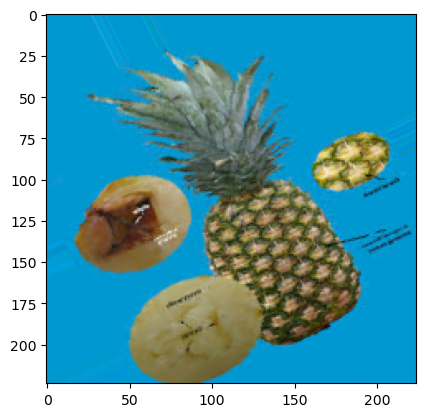

In [12]:
plt.imshow(X_augmented[30])

In [13]:
X = np.concatenate((X, X_augmented))
y = np.concatenate((y, y_augmented))

In [14]:
X.shape, y.shape

((4602, 224, 224, 3), (4602, 10))

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(3681, 224, 224, 3) (3681, 10)
(921, 224, 224, 3) (921, 10)


### 3.Cấu hình model

Sử dụng mạng inception_v3 với bộ các trọng số từ bộ dữ liệu imagenet đã được train

In [17]:
base_model = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [18]:
len(base_model.layers)

311

In [19]:
x = base_model.output
x =Conv2D(64, 3, activation = 'relu')(x)
x =Conv2D(64, 3, activation = 'relu')(x)
# x = BatchNormalization(axis=1)(x)
x = Dropout(0.5)(x)

x = MaxPooling2D(2, padding='same')(x)
x = Flatten()(x)

# FC
x = layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.1))(x)
x = Dropout(0.5)(x)
x = BatchNormalization(axis=1)(x)
x = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = x)

In [20]:
model = models.Model(inputs = base_model.input, outputs = x)

In [21]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 111, 111, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 111, 111, 32)      │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 111, 111, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 109, 109, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 109, 109, 32)      │              96 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 109, 109, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 109, 109, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 109, 109, 64)      │             192 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 109, 109, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 54, 54, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 54, 54, 80)        │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 54, 54, 80)        │             240 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 54, 54, 80)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 52, 52, 192)       │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,100,330 (88.12 MB)

 Trainable params: 23,063,850 (87.98 MB)

 Non-trainable params: 36,480 (142.50 KB)

In [22]:
len(model.layers)

320

In [23]:
for layer in model.layers[:252]:
    layer.trainable = False
for layer in model.layers[252:]:
    layer.trainable = True

In [24]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

### 3. Training

In [25]:
history = model.fit(X_train, y_train, epochs=60, validation_data=(X_val, y_val), verbose=1, batch_size=64)

Epoch 1/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.2208 - loss: 11.0708 - val_accuracy: 0.7709 - val_loss: 3.8478
Epoch 2/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7345 - loss: 2.6987 - val_accuracy: 0.8578 - val_loss: 1.5127
Epoch 3/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8766 - loss: 1.1320 - val_accuracy: 0.8784 - val_loss: 0.8437
Epoch 4/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9385 - loss: 0.6006 - val_accuracy: 0.9110 - val_loss: 0.6474
Epoch 5/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9503 - loss: 0.4506 - val_accuracy: 0.8817 - val_loss: 0.6908
Epoch 6/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9681 - loss: 0.3441 - val_accuracy: 0.9153 - val_loss: 0.5129
Epoch 7/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9647 - loss: 0.3322 - val_accuracy: 0.9316 - val_loss: 0.5217
Epoch 8/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9767 - loss: 0.2839 - val_accuracy: 0.9110 - val_loss

Epoch 52/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9872 - loss: 0.2478 - val_accuracy: 0.9381 - val_loss: 0.5860
Epoch 53/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9937 - loss: 0.2426 - val_accuracy: 0.9511 - val_loss: 0.5218
Epoch 54/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9905 - loss: 0.2432 - val_accuracy: 0.9511 - val_loss: 0.4767
Epoch 55/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9922 - loss: 0.1996 - val_accuracy: 0.9522 - val_loss: 0.4900
Epoch 56/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9913 - loss: 0.2424 - val_accuracy: 0.9544 - val_loss: 0.4749
Epoch 57/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9946 - loss: 0.2345 - val_accuracy: 0.9501 - val_loss: 0.4318
Epoch 58/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9927 - loss: 0.1959 - val_accuracy: 0.9522 - val_loss: 0.4463
Epoch 59/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9921 - loss: 0.2298 - val_accuracy: 0.9620 - 

In [26]:
score = model.evaluate(X_test, y_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.8710 - loss: 0.9404


In [27]:
score

[0.8572670817375183, 0.880975604057312]

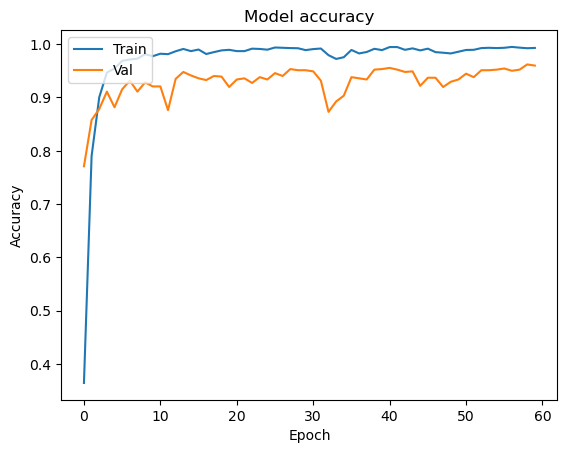

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [29]:
y_predict = model.predict(X_test)
predicted_classes = np.argmax(y_predict, axis=1)

33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 444ms/step


In [30]:
def plot_data(x_data: np.ndarray, y_data: np.ndarray) -> None:
    nrows, ncols = 2, 4
    fig, axes = plt.subplots(nrows, ncols, figsize=(8, 4))
    
    len_x = x_data.shape[0]
    for i in range(nrows * ncols):
        ax = axes[i // ncols, i % ncols]
        
        img_index = random.randint(0, len_x)
        
        ax.imshow(x_data[img_index])
        ax.set(xticks=[], yticks=[])
        
        true_label_str = 'Dự đoán: ' + classes[y_data[img_index]]
        ax.set_xlabel(true_label_str, color='green', fontsize = 12)
    plt.tight_layout()
    plt.show()

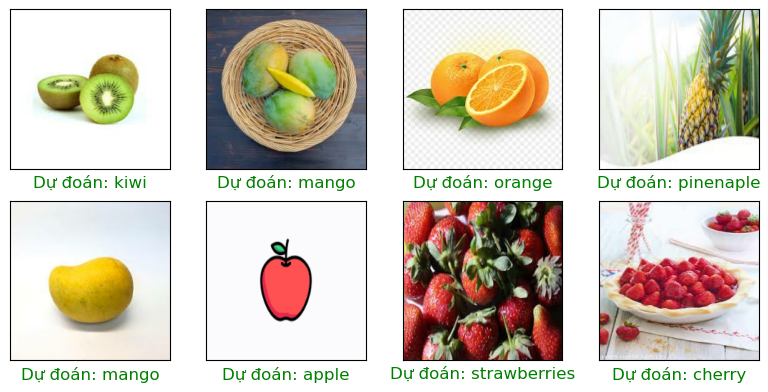

In [31]:
plot_data(X_test, predicted_classes)

In [33]:
model.save('classify-fruit.keras')